## Importing packages

In [1]:
import os
from sklearn import cross_validation
import pandas as pd
import tsfresh
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import confusion_matrix, roc_curve, auc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import shuffle
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multiclass import OneVsRestClassifier

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
column_names = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23","activity"]
def read_file(file, activity):
    temp_df = pd.read_csv(file, skiprows=range(0, 4), usecols=[1,2,3,4,5,6])
    temp_df["activity"] = activity
    temp_df.columns = column_names 
    return temp_df

In [3]:
def extract_features(temp_df):
    features = []
    for column in temp_df.columns:
        if column == "activity":
            continue
        s = pd.Series(temp_df[column])
        features += [min(s), max(s), np.mean(s), np.median(s), np.std(s), s.quantile(0.25), s.quantile(0.75)]
    return features

In [4]:
all_features = ["min","max","mean","median","sd","quar0.25","quar0.75"]

In [5]:
def split_file(df, split):
    split_len = int(len(df)/split)
    beg = 0
    end = split_len
    extraction = []
    i = 0
    for i in range(split-1):
        beg = split_len*i
        end = split_len*(i+1)
        extraction += extract_features(pd.DataFrame(columns = column_names, data = df.iloc[beg:end,]))
    if split == 1:
        i = 0
    else:
        i+=1
    beg = split_len*i
    extraction += extract_features(pd.DataFrame(columns = column_names, data = df.iloc[beg:,]))
    return extraction

In [6]:
activities = ['bending1', 'bending2', 'cycling', 'standing', 'lying', 'walking', 'sitting']

In [7]:
def read_and_split(what_data, split):
    split_features = []
    for i in range(split):
        for k in range(len(column_names)-1):
            for f in all_features:
                split_features.append(f+"_"+str(k+1)+"_"+str(i+1))
    split_features.append("activity")
    final = pd.DataFrame(columns = split_features)
    for activity in activities:
        for file in os.listdir(what_data+"/"+activity):
            if file == ".DS_Store":
                continue
            df = read_file(what_data+"/"+activity+"/"+file, activity)
            row = split_file(df, split)
            row.append(activity)
            final.loc[len(final)] = row
    return final

## C) i) Time Domain Features
### The time domain features usually used are as follows:
- Minimum : The minimum value for a particular column.
- Maximum : The maximum value for a paticular column.
- Mean : Mean of the column.
- Median : Median of the column.
- Standard Deviation : Standard Deviation of the column.
- First Quartile : 0.25
- Second Quartile : 0.55
- Third Quartile : 0.75
- Kurtosis : The sharpness of the peak of a frequency-distribution curve.
- Skewness : Indicates the symmetry of probability density function of the amplitude of a time series.

## C) ii) Extracting time domain features
#### The helper function <i>"calculate_time_domain_features"</i> defined above calculates all the time domain features. (Modularized code for less repetition)

In [8]:
train_data = read_and_split("train_data", 1)
test_data = read_and_split("test_data", 1)
data = pd.concat([train_data, test_data], ignore_index=True)
data.activity = data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
data.head()

,min_1_1,max_1_1,mean_1_1,median_1_1,sd_1_1,quar0.25_1_1,quar0.75_1_1,min_2_1,max_2_1,mean_2_1,...,quar0.25_5_1,quar0.75_5_1,min_6_1,max_6_1,mean_6_1,median_6_1,sd_6_1,quar0.25_6_1,quar0.75_6_1,activity
0,36.25,48.00,43.969125,44.50,1.616677,43.31,44.67,0.0,1.50,0.413125,...,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487318,0.00,0.83,1
1,37.00,48.00,43.454958,43.25,1.384653,42.50,45.00,0.0,1.58,0.378083,...,22.2500,24.00,0.0,5.26,0.679646,0.50,0.621885,0.43,0.87,1
2,33.00,47.75,42.179812,43.50,3.666840,39.15,45.00,0.0,3.00,0.696042,...,30.4575,36.33,0.0,2.18,0.613521,0.50,0.523771,0.00,1.00,1
3,33.00,45.75,41.678063,41.75,2.241152,41.33,42.75,0.0,2.83,0.535979,...,28.4575,31.25,0.0,1.79,0.383292,0.43,0.388759,0.00,0.50,1
4,35.00,47.40,43.954500,44.33,1.557210,43.00,45.00,0.0,1.70,0.426250,...,35.3625,36.50,0.0,1.79,0.493292,0.43,0.512971,0.00,0.94,1


## C) iii) Building a 90% bootsrap confidence interval for the standard deviation of each feature

In [9]:
CI = pd.DataFrame(columns = ["Feature", "SD w/o Bootstrapping", "Lower Limit", "Upper Limit"])
for column in data.columns[:-1]:
    boot = []
    values = list(data[column])
    sd = np.std(values)
    for i in range(0,1000):
        boot.append(np.std(resample(values)))
    boot.sort()
    s = pd.Series(boot)
    CI.loc[len(CI)] = [column, sd, s.quantile(0.05), s.quantile(0.95)]
CI

,Feature,SD w/o Bootstrapping,Lower Limit,Upper Limit
0,min_1_1,9.515445,8.233345,10.671538
1,max_1_1,4.369322,3.326504,5.246605
2,mean_1_1,5.305314,4.736397,5.885213
3,median_1_1,5.409056,4.751682,5.940297
4,sd_1_1,1.760219,1.555780,1.939837
5,quar0.25_1_1,6.118526,5.526657,6.586861
6,quar0.75_1_1,5.109643,4.314977,5.756538
7,min_2_1,0.000000,0.000000,0.000000
8,max_2_1,5.033882,4.594564,5.362843
9,mean_2_1,1.565194,1.397057,1.696321


## C) iv) 3 most important features should be:
- Median : If certain values repeat themselves in every column for every label, they will act ads a significant feature.
- Max : Out of Max and Min, Max makes more sense to use since min values are 0 for a lot of the columns.
- Mean : For a time series, if a particular value repeats for every column distinctively, it would be a good feature to use.

In [10]:
mif = ["median", "max", "mean"]

## D) Binary Classification Using Logistic Regression

## i) Scatterplot of time-domain features <i>mean, max and median</i> of columns 1, 2 and 6

In [11]:
scatter = []
for f in mif:
    for count in [1,2,6]:
        for split in range(1,2):
            scatter.append(f+"_"+str(count)+"_"+str(split))
scatter.append("activity")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


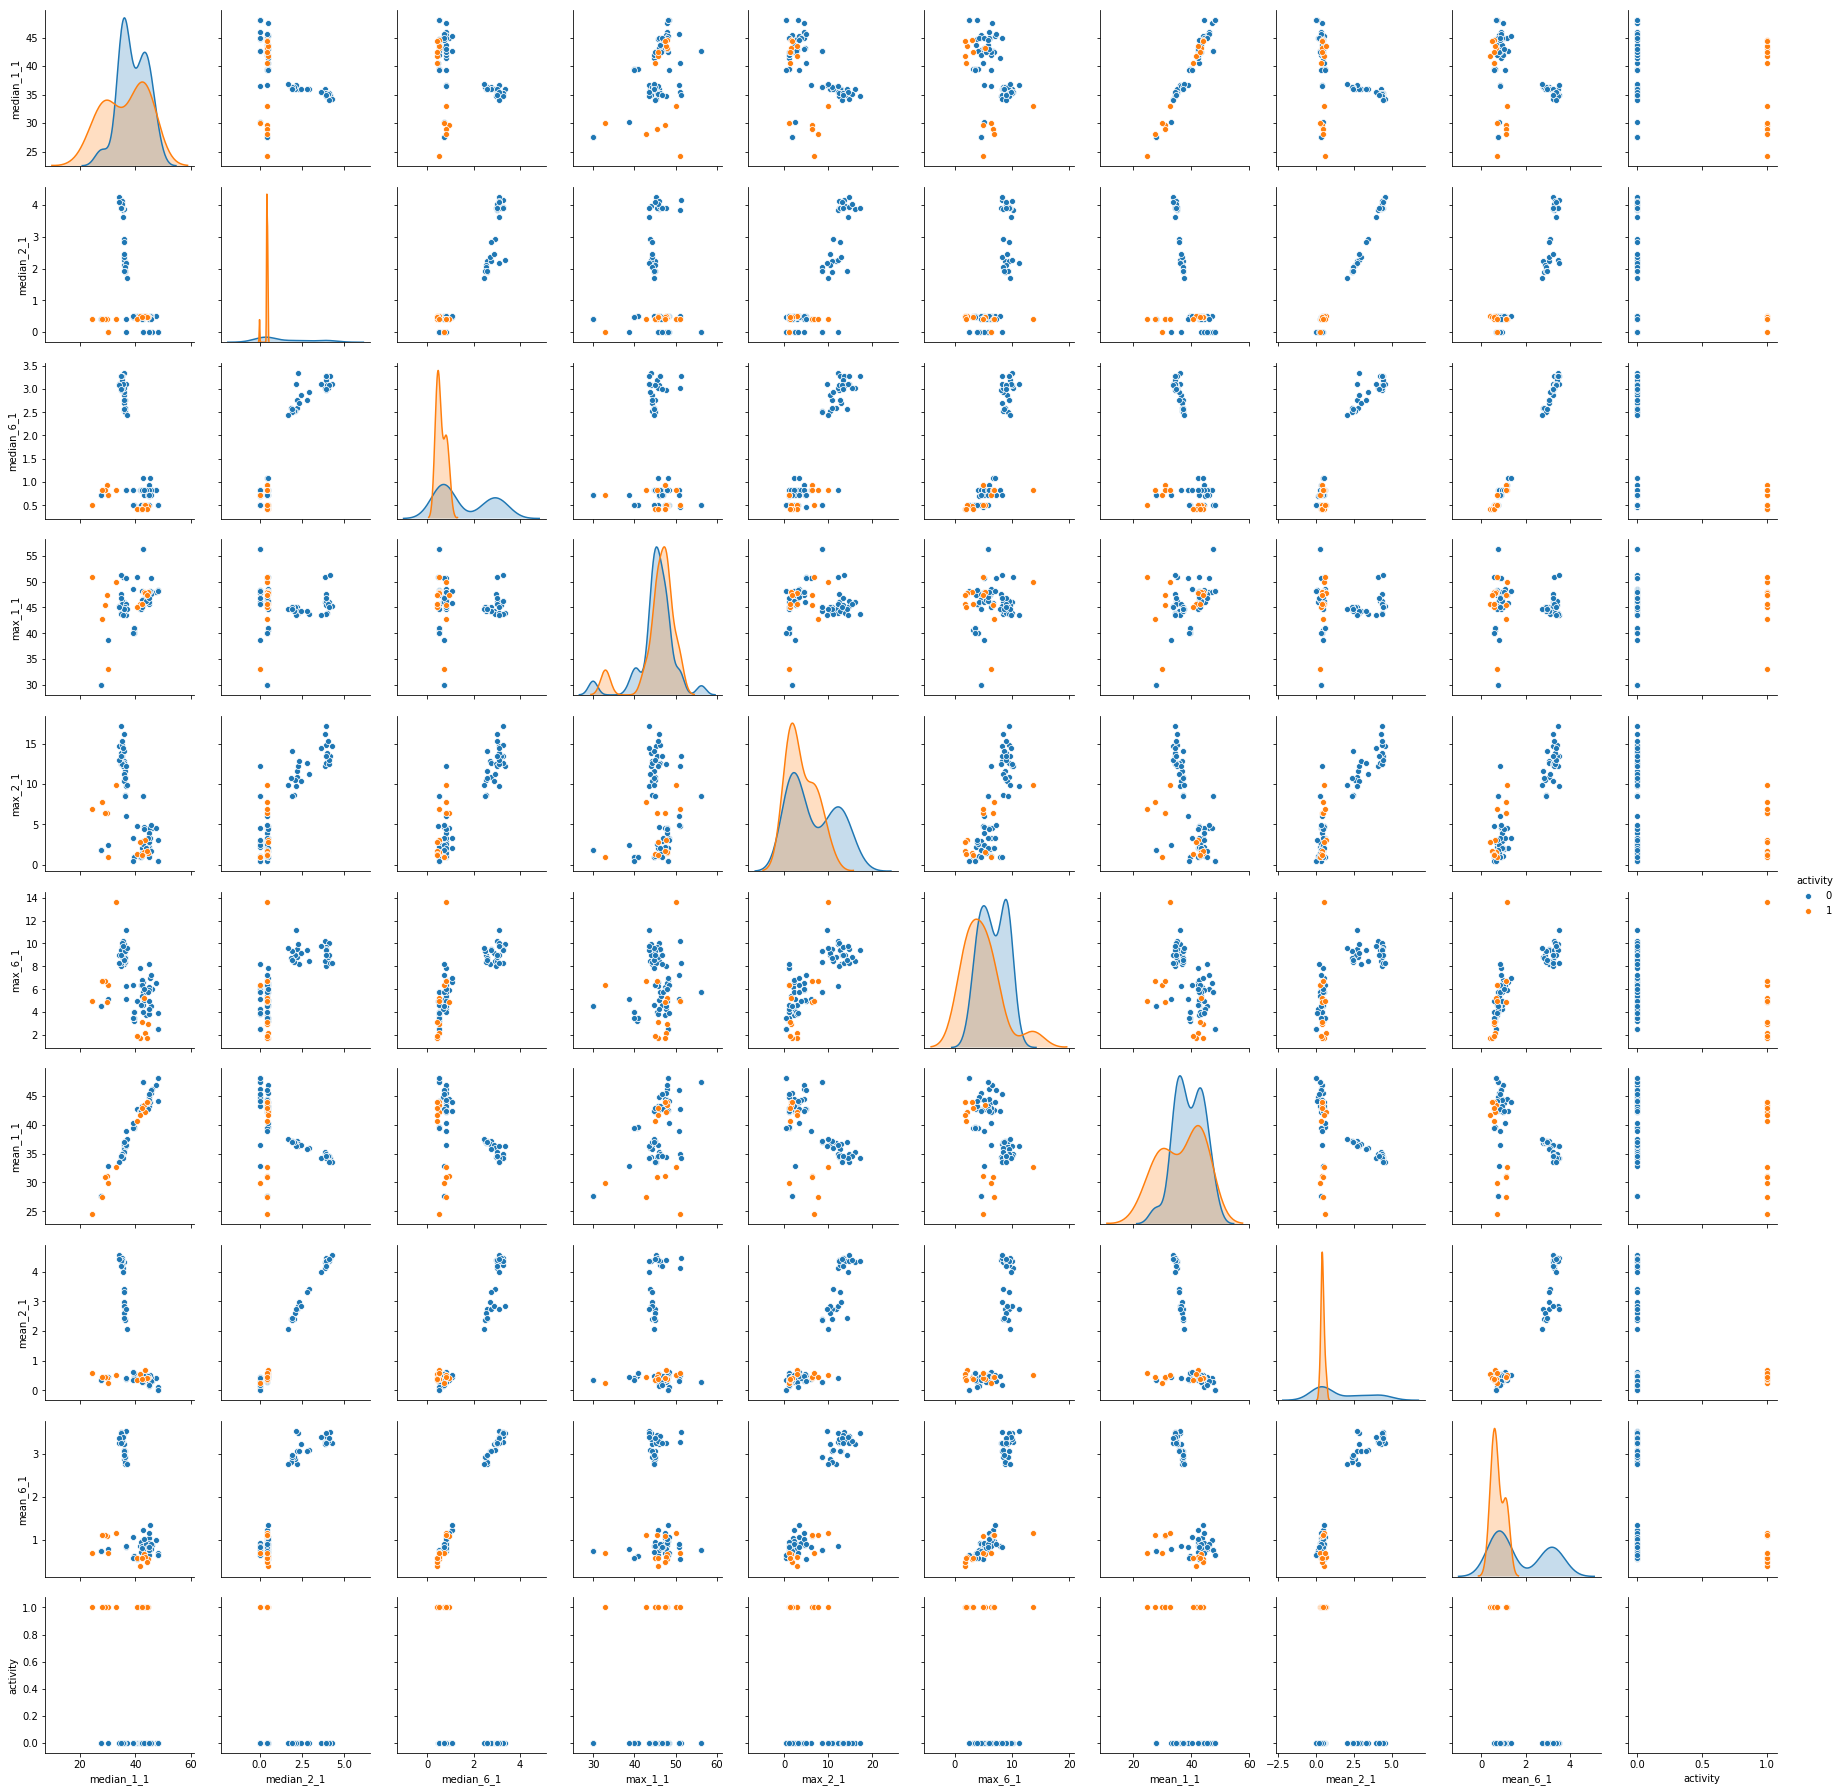

In [12]:
sns.pairplot(data = data[scatter], hue = "activity")

## D) ii) Breaking each time series into 2 and making scatterplots

In [15]:
scatter = []
for f in mif:
    for count in [1,2,6]:
        for split in range(1,3):
            scatter.append(f+"_"+str(count)+"_"+str(split))
scatter.append("activity")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


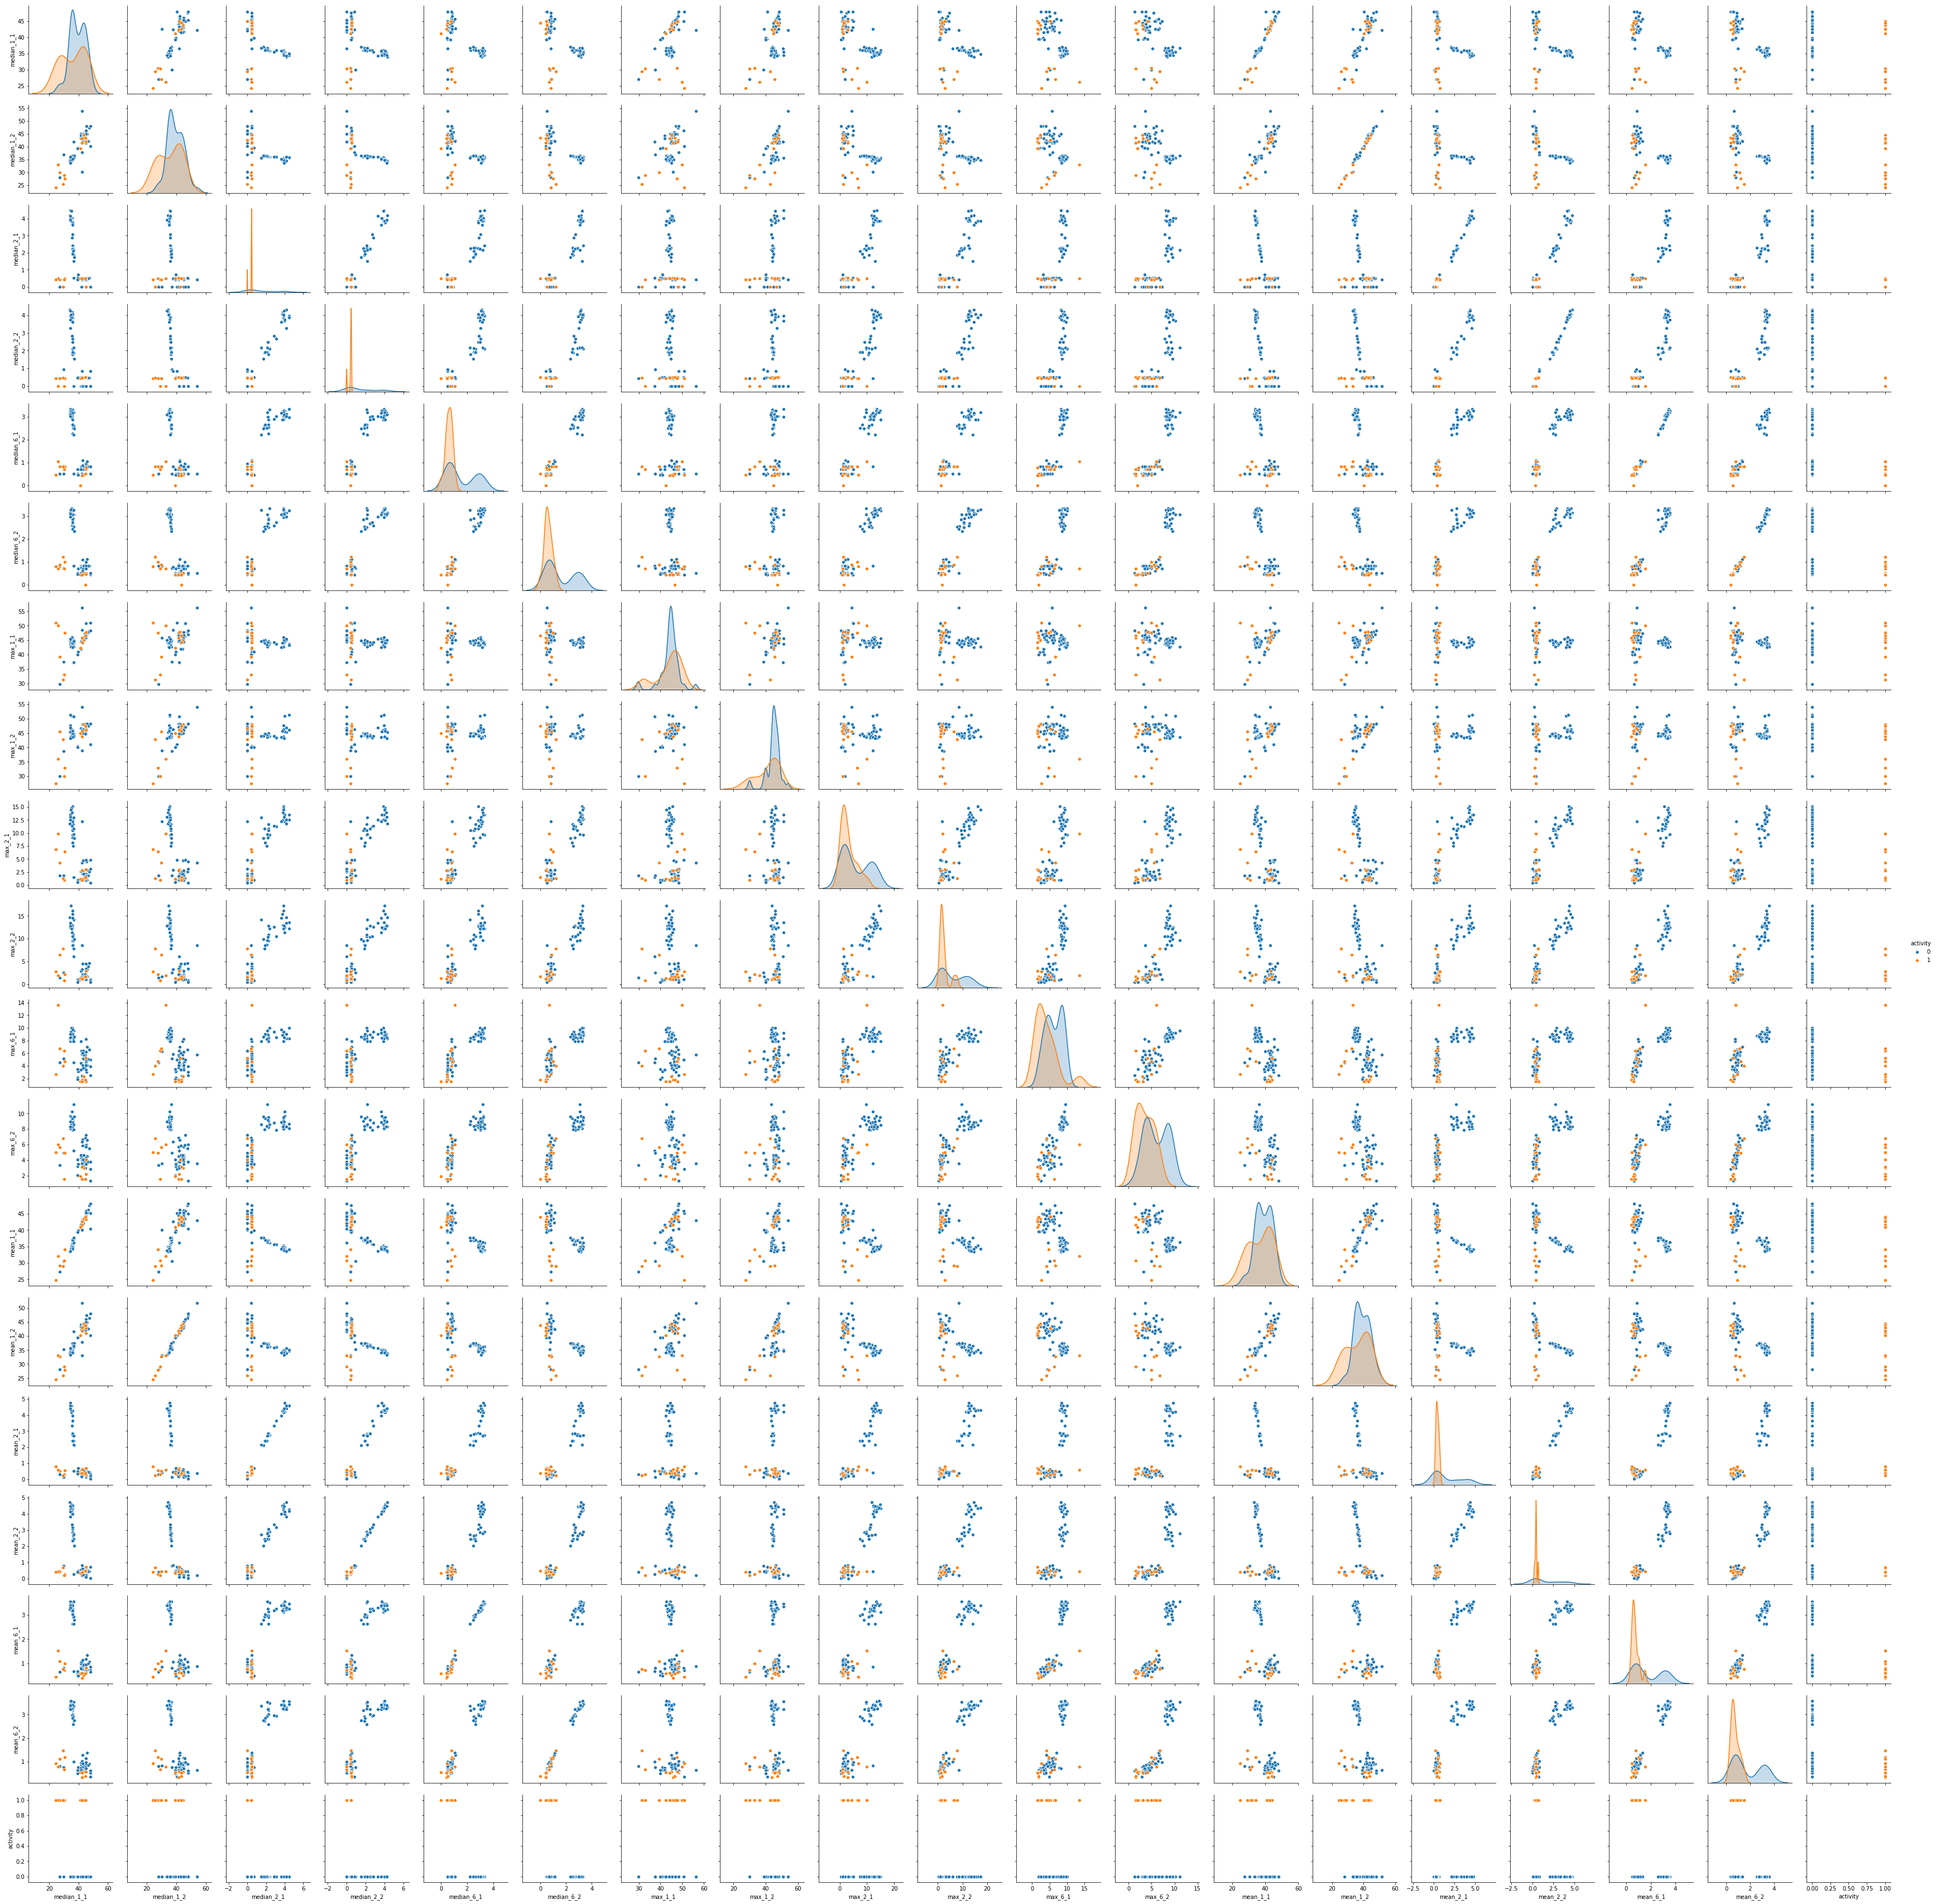

In [14]:
train_data = read_and_split("train_data", 2)
test_data = read_and_split("test_data", 2)
data = pd.concat([train_data, test_data], ignore_index=True)
data.activity = data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
sns.pairplot(data = data[scatter], hue = "activity")

#### After splitting the data into 2, we can see that only an insignificant number of features help us show the difference between the data. Hence, splitting the data into 2 parts does not seem to be very useful.

## D) iii) Break each time series in your training set into l ∈ {1, 2, . . . , 20}

### Approach
- We keep the outermost loop as the loop that iteartes over the L values.
- We will use 5-Fold Startified cross validation to find the best L.
- <i>REASON FOR USING STRATIFIED K FOLD</i>
 * Since the number of non-bending instances are way more that bending, using normal K fold may result in some of the folds having instances of only 1 class (the "other" class).
 * StratifiedKFold takes care of this for us.
- Instead of P values, we will use the REFCV function in python that by default does recursive feature elimination and also performs cross validation on it.
- <i>RIGHT WAY TO DO CROSS VALIDATION</i>
 * We DON'T include the entire data for feature selection while cross-validating. We make feature selection a part of the cross validation by putting it inside the cross validation loop.
- <i>WRONG WAY TO DO CROSS VALIDATION</i>
 * We do feature selection first on the entire data and then cross validate. This is wrong since the model has already seen the entire data and now will be biased towards the test instance of cross-validation also.
 
 
- On cross validating, we take the average of all the scores and see which of them is highest. The L value corresponding to highest average value is the best L. In case of a tie, we take the lower L.

In [18]:
d3_summary = pd.DataFrame(columns = ["Split Value", "Score"])

In [19]:
for l in range(1,21):
    train_data = read_and_split("train_data", l)
    X_train = train_data.drop(["activity"], axis = 1)
    Y_train = train_data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
    kf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        selector = RFECV(LogisticRegression(), step = 1)
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    d3_summary.loc[len(d3_summary)] = [int(l), avg_score]

In [25]:
d3_summary = d3_summary.sort_values(['Score'], ascending=False)
d3_summary

,Split Value,Score
19,20.0,0.891667
17,18.0,0.891667
0,1.0,0.875000
13,14.0,0.841667
9,10.0,0.841667
12,13.0,0.841667
2,3.0,0.833333
11,12.0,0.825000
8,9.0,0.791667
14,15.0,0.791667


### Since Best L value is 18 and 20, we take 18 since it is lower.

In [26]:
best_L_value = int(d3_summary.iloc[1]["Split Value"])
best_L_value

18

#### Reading data for best L Value

In [27]:
X_train = read_and_split("train_data", best_L_value)
Y_train = X_train.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
X_test = read_and_split("test_data", best_L_value)
Y_test = X_test.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})

### iv) ROC, AUC, Beta Values and P-Values
### v) Using test set to analyze 
- Now that we have the best L value, we fit the model again to find the best features.
- Than all the required ouputs have been calculated.

In [30]:
selector = RFECV(LogisticRegression(), step = 1)
selector = selector.fit(X_train.drop(["activity"], axis = 1), Y_train)
support = selector.get_support()
fu = []
for i in range(len(support)):
    if support[i] == 1:
        fu.append(X_train.columns[i])
coeff = selector.estimator_.coef_
print("SUMMARIZING FEATURES : ")
print()
print("Features Selected and their coeff: ")
for i in range(len(fu)):
    print(fu[i], ":", coeff[0][i])
print()
print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train.drop(["activity"], axis = 1))))
print("\nConfusion Matrix : Train data: ")
c = confusion_matrix(Y_train, selector.predict(X_train.drop(["activity"], axis = 1)))

print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_train, selector.predict(X_train.drop(["activity"], axis = 1))))
print("\nConfusion Matrix : Test data: ")
c = confusion_matrix(Y_test, selector.predict(X_test.drop(["activity"], axis = 1)))

print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

l = sm.Logit(Y_train, X_train[fu])
print()
try:
    l.fit()
except Exception as e:
    print(e)

SUMMARIZING FEATURES : 

Features Selected and their coeff: 
min_5_2 : 0.17577896260692377
min_5_3 : 0.2639664257274408
mean_5_3 : 0.1892177821962813
quar0.25_5_3 : 0.23646310252804695
max_1_11 : -0.2643752383288223
max_1_13 : -0.2755802054235399
min_5_17 : 0.3596525866011918


ROC AUC score : Train data: 
1.0

Confusion Matrix : Train data: 
True Negative =  60
False Negative =  0
True Positive =  9
False Positive =  0

ROC AUC score : Test data: 
1.0

Confusion Matrix : Test data: 
True Negative =  15
False Negative =  0
True Positive =  4
False Positive =  0
Perfect separation detected, results not available


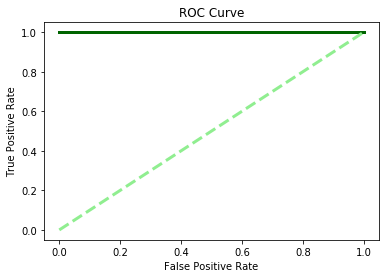

In [44]:
fpr, tpr, _ = roc_curve(Y_test, selector.predict(X_test.drop(["activity"], axis = 1)))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkgreen',lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgreen', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### vi) As we can see above, the classes are definetely well seperated, and hence we get the PerfectSeperationError (message of the error is printed by the except block). This causes instability in calculating logistic regression parameters.

### vii) Since imbalanced classes exist, we can use the imblearn package to do RandomUnderSampleing. In this scenario, we reduce the number of observations for the class that is causing the imbalance.

In [53]:
d7_summary = pd.DataFrame(columns = ["Split Value", "Score"])

In [54]:
def balance_data(df):
    rus = RandomUnderSampler()
    x, y = rus.fit_sample(df.drop(["activity"], axis = 1), df.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0}))
    rows = []
    for i in range(len(x)):
        row = list(x[i])
        row.append(y[i])
        rows.append(row)
    train_data = pd.DataFrame(columns = df.columns, data = rows)
    X_train = train_data.drop(["activity"], axis = 1)
    Y_train = train_data.activity
    return X_train, Y_train

In [55]:
for l in range(1, 21):
    train_data = read_and_split("train_data", l)
    X_train, Y_train = balance_data(train_data)
    kf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        selector = RFECV(LogisticRegression(class_weight = "balanced"), step = 1)
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    d7_summary.loc[len(d7_summary)] = [int(l), avg_score]

In [56]:
d7_summary = d7_summary.sort_values(['Score'], ascending=False)
d7_summary

,Split Value,Score
0,1.0,1.00
13,14.0,1.00
19,20.0,1.00
11,12.0,0.95
2,3.0,0.95
5,6.0,0.95
6,7.0,0.95
18,19.0,0.95
1,2.0,0.95
4,5.0,0.95


In [58]:
best_L_value = int(d7_summary.iloc[0]["Split Value"])
best_L_value

1

In [63]:
train_data = read_and_split("train_data", best_L_value)
X_train, Y_train = balance_data(train_data)
test_data = read_and_split("test_data", best_L_value)
X_test, Y_test = balance_data(test_data)

In [64]:
selector = RFECV(LogisticRegression(class_weight = "balanced"), step = 1)
selector = selector.fit(X_train, Y_train)
support = selector.get_support()
fu = []
for i in range(len(support)):
    if support[i] == 1:
        fu.append(X_train.columns[i])
print("Features Selected: ")
print(fu)
print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train)))
print()
print("TRAIN CONFUSION MATRIX")
c = confusion_matrix(Y_train, selector.predict(X_train))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_test, selector.predict(X_test)))
print()
print("TEST CONFUSION MATRIX")
c = confusion_matrix(Y_test, selector.predict(X_test))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])
print()
l = sm.Logit(Y_train, X_train[fu])
try:
    l.fit()
except Exception as e:
    print(e)

Features Selected: 
['min_1_1', 'max_1_1', 'mean_1_1', 'median_1_1', 'sd_1_1', 'quar0.25_1_1', 'quar0.75_1_1', 'min_2_1', 'max_2_1', 'mean_2_1', 'median_2_1', 'sd_2_1', 'quar0.25_2_1', 'quar0.75_2_1', 'min_3_1', 'max_3_1', 'mean_3_1', 'median_3_1', 'sd_3_1', 'quar0.25_3_1', 'quar0.75_3_1', 'min_4_1', 'max_4_1', 'mean_4_1', 'median_4_1', 'sd_4_1', 'quar0.25_4_1', 'quar0.75_4_1', 'min_5_1', 'max_5_1', 'mean_5_1', 'median_5_1', 'sd_5_1', 'quar0.25_5_1', 'quar0.75_5_1', 'min_6_1', 'max_6_1', 'mean_6_1', 'median_6_1', 'sd_6_1', 'quar0.25_6_1', 'quar0.75_6_1']

ROC AUC score : Train data: 
1.0

TRAIN CONFUSION MATRIX

True Negative =  9
False Negative =  0
True Positive =  9
False Positive =  0

ROC AUC score : Test data: 
1.0

TEST CONFUSION MATRIX

True Negative =  4
False Negative =  0
True Positive =  4
False Positive =  0

Perfect separation detected, results not available


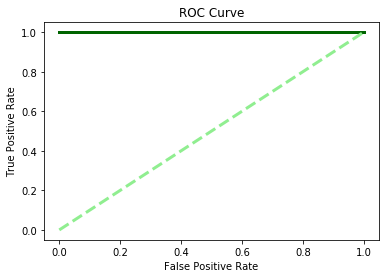

In [66]:
fpr, tpr, _ = roc_curve(Y_test, selector.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkgreen',lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgreen', lw=3, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## E) Binary Classification Using L1-penalized logistic regression

### i)
- Using L1 regularization by giving penalty = "l1" and solver = "liblinear" to the model.
- We use LogisticRegressionCV as it automatuically cross validates over C (the budget)
- Using RFE instead of RFECV else the model takes too long to stabilize. We set n_features_to_select to 6.

In [101]:
e1_summary = pd.DataFrame(columns = ["Split Value", "Score"])

In [102]:
for l in range(1,21):
    train_data = read_and_split("train_data", l)
    train_data.activity = train_data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
    train_data = pd.DataFrame(columns = train_data.columns, data = MinMaxScaler().fit_transform(train_data))
    X_train = train_data.drop(["activity"], axis = 1)#[f]
    Y_train = train_data.activity
    kf = StratifiedKFold(n_splits=5)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
        selector = selector.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = roc_auc_score(Y_train.iloc[test_index], selector.predict(X_train.iloc[test_index]))
        scores.append(score)
    avg_score = np.mean(scores)
    e1_summary.loc[len(e1_summary)] = [int(l), avg_score]

In [103]:
e1_summary = e1_summary.sort_values(['Score'], ascending=False)
e1_summary

,Split Value,Score
0,1.0,0.833333
1,2.0,0.775000
2,3.0,0.775000
6,7.0,0.775000
12,13.0,0.758333
3,4.0,0.733333
4,5.0,0.725000
19,20.0,0.691667
9,10.0,0.683333
13,14.0,0.675000


In [104]:
best_L_value = int(e1_summary.iloc[0]["Split Value"])
best_L_value

1

In [105]:
train_data = read_and_split("train_data", best_L_value)
train_data.activity = train_data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
train_data = pd.DataFrame(columns = train_data.columns, data = MinMaxScaler().fit_transform(train_data))
X_train = train_data.drop(["activity"], axis = 1)#[f]
Y_train = train_data.activity

test_data = read_and_split("test_data", best_L_value)
test_data.activity = test_data.activity.map({"bending1":1, "bending2":1, "cycling":0, 'standing':0, 'lying':0, 'walking':0, 'sitting':0})
test_data = pd.DataFrame(columns = test_data.columns, data = MinMaxScaler().fit_transform(test_data))
X_test = test_data.drop(["activity"], axis = 1)#[f]
Y_test = test_data.activity

In [108]:
selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
selector = selector.fit(X_train, Y_train)

print("\nROC AUC score : Train data: ")
print(roc_auc_score(Y_train, selector.predict(X_train)))

print("\nTRAIN CONFUSION MATRIX")
c = confusion_matrix(Y_train, selector.predict(X_train))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])

print("\nROC AUC score : Test data: ")
print(roc_auc_score(Y_test, selector.predict(X_test)))

print("\nTEST CONFUSION MATRIX")
c = confusion_matrix(Y_test, selector.predict(X_test))
print()
print("True Negative = ", c[0][0])
print("False Negative = ", c[1][0])
print("True Positive = ", c[1][1])
print("False Positive = ", c[0][1])
print()
print("BEST VALUE OF C : ")
print(selector.C_)


ROC AUC score : Train data: 
0.9444444444444444

TRAIN CONFUSION MATRIX

True Negative =  60
False Negative =  1
True Positive =  8
False Positive =  0

ROC AUC score : Test data: 
1.0

TEST CONFUSION MATRIX

True Negative =  15
False Negative =  0
True Positive =  4
False Positive =  0

BEST VALUE OF C : 
[2.7825594]


## ii) Comparison
- From the summary tables above, we can see that for our case, L1-penalized logistic regression performs slightly worse that the Normal Logistic Regression with cross validated feature selection since ROC AUC score for train data of the l1-Penalized Model is slightly lower than that of the normal model. But this is not a fixed case, it can vary depending on the data. 
- Implementation wise, normal Logistic Regression is defintely better since we have 1 parameter less to cross validate over.

## F) Multi-Class Classification

### i) Using L1 Penalized Multinomial Regression

In [109]:
multiclass_summary = pd.DataFrame(columns = ["Split Value", "Score"])

In [110]:
for l in range(1,21):
    train_data = read_and_split("train_data", l)
    X_train = train_data.drop(["activity"], axis = 1)
    Y_train = train_data.activity
    kf = StratifiedKFold(n_splits=4)
    scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        lr = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
        lr.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        score = lr.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        scores.append(score)
    avg_score = np.mean(scores)
    print([int(l), avg_score])
    multiclass_summary.loc[len(multiclass_summary)] = [int(l), avg_score]

[1, 0.7254901960784315]
[2, 0.7246732026143791]
[3, 0.6821895424836601]
[4, 0.7099673202614379]
[5, 0.6233660130718954]
[6, 0.6519607843137255]
[7, 0.6372549019607843]
[8, 0.6813725490196079]
[9, 0.6372549019607843]
[10, 0.6519607843137255]
[11, 0.5947712418300654]
[12, 0.6225490196078431]
[13, 0.5939542483660131]
[14, 0.5939542483660132]
[15, 0.6527777777777778]
[16, 0.579248366013072]
[17, 0.5506535947712418]
[18, 0.5359477124183006]
[19, 0.5939542483660132]
[20, 0.5661764705882353]


In [111]:
multiclass_summary = multiclass_summary.sort_values(['Score'], ascending=False)
multiclass_summary

,Split Value,Score
0,1.0,0.725490
1,2.0,0.724673
3,4.0,0.709967
2,3.0,0.682190
7,8.0,0.681373
14,15.0,0.652778
5,6.0,0.651961
9,10.0,0.651961
6,7.0,0.637255
8,9.0,0.637255


In [124]:
best_L_value = int(multiclass_summary.iloc[0]["Split Value"])
best_L_value

1

In [125]:
train_data = read_and_split("train_data", best_L_value)
X_train = train_data.drop(["activity"], axis = 1)
Y_train = train_data.activity
test_data = read_and_split("test_data", best_L_value)
X_test = test_data.drop(["activity"], axis = 1)
Y_test = test_data.activity

In [126]:
selector = LogisticRegressionCV(penalty = "l1", cv = 3, solver = "liblinear")
selector = selector.fit(X_train, Y_train)

print("TRAINING SCORE")
print(selector.score(X_train, Y_train))
print("TESTING SCORE")
print(selector.score(X_test, Y_test))

TRAINING SCORE
0.9855072463768116
TESTING SCORE
0.7894736842105263


### Since confusion matrix is nothing but a general representation of a matrix where the rows indicate the actual class and columns indicate the predicted class, we can create a Confusion Matrix for multiclass classification.

In [137]:
print("Confusion Matrix for train Data")
c = [[0 for activity in activities] for activity in activities]
pred = selector.predict(X_train)
for i in range(len(pred)):
    c[activities.index(Y_train[i])][activities.index(pred[i])] += 1
c = pd.DataFrame(columns = activities, data = c, index = activities)
print(c)
print()
print("Confusion Matrix for test Data")
c = [[0 for activity in activities] for activity in activities]
pred = selector.predict(X_test)
for i in range(len(pred)):
    c[activities.index(Y_test[i])][activities.index(pred[i])] += 1
c = pd.DataFrame(columns = activities, data = c, index = activities)
print(c)

Confusion Matrix for train Data
          bending1  bending2  cycling  standing  lying  walking  sitting
bending1         5         0        0         0      0        0        0
bending2         1         3        0         0      0        0        0
cycling          0         0       12         0      0        0        0
standing         0         0        0        12      0        0        0
lying            0         0        0         0     12        0        0
walking          0         0        0         0      0       12        0
sitting          0         0        0         0      0        0       12

Confusion Matrix for test Data
          bending1  bending2  cycling  standing  lying  walking  sitting
bending1         2         0        0         0      0        0        0
bending2         0         0        0         0      0        0        2
cycling          0         0        3         0      0        0        0
standing         0         0        0         2      1      

## ii) Naive Bayes

In [138]:
nb_summary = pd.DataFrame(columns = ["Split Value", "Multinomial Score", "Gaussian Score"])

In [120]:
for l in range(1, 21):
    train_data = read_and_split("train_data", l)
    X_train = train_data.drop(["activity"], axis = 1)#[f]
    Y_train = train_data.activity
    kf = StratifiedKFold(n_splits=4)
    mnb_scores = []
    gnb_scores = []
    for train_index, test_index in kf.split(X_train, Y_train):
        mnb = MultinomialNB()
        gnb = GaussianNB()
        mnb.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        gnb.fit(X_train.iloc[train_index], Y_train.iloc[train_index])
        mnb_score = mnb.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        gnb_score = gnb.score(X_train.iloc[test_index], Y_train.iloc[test_index])
        mnb_scores.append(mnb_score)
        gnb_scores.append(gnb_score)
    mnb_avg = np.mean(mnb_scores)
    gnb_avg = np.mean(gnb_scores)
    nb_summary.loc[len(nb_summary)] = [int(l), mnb_avg, gnb_avg]

In [121]:
nb_summary

,Split Value,Multinomial Score,Gaussian Score
0,1.0,0.840686,0.810458
1,2.0,0.753268,0.782680
2,3.0,0.782680,0.655229
3,4.0,0.783497,0.596405
4,5.0,0.797386,0.611111
5,6.0,0.782680,0.655229
6,7.0,0.768791,0.609477
7,8.0,0.783497,0.681373
8,9.0,0.754902,0.594771
9,10.0,0.739379,0.609477


### iii) As seen from the above table, Multinomial Naive Bayes performs better than Gaussian Naive Bayes in our case for almost all values of L.